## Chat-bot training

In [1]:
from libs.word2vec import Word2vec
from libs.data_loader import loader
from libs.seq2seq import seq2seq_chatbot
import matplotlib.pyplot as plt 
import tensorflow as tf
import numpy as np
import jieba
import os
import time

- Define model name and sentence (word sequence) length

In [2]:
model_name = 'test2'
sent_len = 10

- Create the model folder
- Word to vector training
- Create dictionaries used for lookup
- Load the data and pre-processing

In [3]:
# new model
_ = os.system('mkdir ./model/'+model_name)

# new word2vec model
word2vec_lookup = Word2vec(model_name)
dloader = loader(word2vec_lookup, mode='new', model_name=model_name)

# pre-trained word2vec model
# dloader = loader(mode='pre_trained', model_name=model_name, sent_len=sent_len)

# loading the training data and pre-processing
dloader.data_loading(sent_len=sent_len)

Building prefix dict from /media/warrents/6A085EA7085E7255/GoogleDriveSync/WarrenTS/Code/Code/Python2.7/IPython_Notebooks/MachineLearning/pecu_course/Final_Chat-bot/Chat_bot/libs/dict_new.txt ...
Loading model from cache /tmp/jieba.u72cdc2b1cbd0cc013fba89dee3138c7a.cache
Loading model cost 1.474 seconds.
Prefix dict has been built succesfully.


Original words in gensim voca: 3130584 , ratio: 0.9661682004168871 
Original words not in gensim voca: 109622 , ratio: 0.03383179958311289
Data loader initializing
mode: new
Creating new dicts...
Saving new dicts at ./model/test2/
done


Building prefix dict from /media/warrents/6A085EA7085E7255/GoogleDriveSync/WarrenTS/Code/Code/Python2.7/IPython_Notebooks/MachineLearning/pecu_course/Final_Chat-bot/Chat_bot/libs/dict_new.txt ...
Loading model from cache /tmp/jieba.u72cdc2b1cbd0cc013fba89dee3138c7a.cache


Pre-processing 1


Loading model cost 1.574 seconds.
Prefix dict has been built succesfully.


Pre-processing 2
Pre-processing done.
sent_seg var is created


- Define the hyperparameters for seq2seq model

In [4]:
# hyperparameters
np.set_printoptions(precision=2)
jieba.set_dictionary('./libs/dict_new.txt')
vec_size = len(dloader.word2vec_lookup['<unk>'])
oneHot_size = dloader.voca_size
enc_len = sent_len
dec_len = enc_len
n_layer1 = 512
l_r = 1e-3
epoch = 8
batch_size = 128
n_hiddens = 2
rnn_cell = tf.contrib.rnn.BasicLSTMCell
op = tf.train.AdamOptimizer
max_gradient_norm = 1

### Seq2seq model
- encoder length = decoder length = 10
- attention model implement
- loss function: sparse softmax with cross entropy
- optimizer: AdamOptimizer

In [5]:
# seq2seq initializing
s2s = seq2seq_chatbot(oneHot_size=oneHot_size,
                      l_r=l_r,
                      vec_list=dloader.vec_list,
                      vec_size=vec_size,
                      enc_len=enc_len,
                      dec_len=dec_len,
                      n_layer1=n_layer1,
                      n_hiddens=n_hiddens,
                      model_name=model_name)
# encoder
word_vec, encoder_output, encoder_state, go = s2s.encoder(rnn_cell=rnn_cell)
# decoder
word_target, word_outputs, Attention_weights = s2s.decoder_attention(rnn_cell=rnn_cell,
                                                                     encoder_output=encoder_output,
                                                                     encoder_state=encoder_state,
                                                                     go=go)
# loos function
loss_all = s2s.loss_func(word_outputs=word_outputs,
                         word_target=word_target)
# optimizer and update step
update_step = s2s.optimizer(op=op,
                            loss_all=loss_all,
                            max_gradient_norm=max_gradient_norm)

- Define the function for predicting the output (with data pre-processing and output decode)

In [6]:
# functions for predicting next sentences
def next_sent(inp):
    inp = list(jieba.cut(inp))
    for j in range(len(inp)):
        if inp[j] in dloader.word2vec_lookup:
            pass
        else:
            inp[j] = '<unk>'
    if len(inp) > sent_len:
        inp = inp[0:sent_len]
    ends = ['<end>' for k in range(sent_len-len(inp))]
    inp += ends
    print(inp)
    batch_x = np.array([[dloader.word2vec_lookup[inp[i]] for i in range(len(inp))]])
    batch_y = np.array([[0 for i in range(dec_len)]])
    resp = list()
    for k in range(dec_len):
        feed_dict = {word_vec[t]: batch_x[:, t] for t in range(enc_len)}
        feed_dict.update({word_target[t]: batch_y[:, t] for t in range(dec_len)})
        
        resp.append(sess.run([word_outputs], feed_dict=feed_dict)[0][k])
        batch_y[0][k] = np.argmax(resp[k])
    print(np.array(sess.run(Attention_weights[0:enc_len], feed_dict=feed_dict)).reshape([-1]))
#     atten_w = np.array(sess.run(Attention_weights, feed_dict=feed_dict)).reshape([-1])
#     atten_avg = list()
#     for i in range(enc_len):
#         atten_avg.append(np.mean([atten_w[i+j*enc_len] for j in range(dec_len)]))
#     print(np.array(atten_avg))
    sent = [dloader.oneHotPos2word[np.argmax(w)] for w in resp]
    return sent
def next_n_sent(inp, n):
    sents = list()
    for i in range(n):
        resp = next_sent(inp)
        sents.append(resp)
        inp = ''.join(sents[i]).replace('<end>', '')
    return sents

- Training

Building prefix dict from /media/warrents/6A085EA7085E7255/GoogleDriveSync/WarrenTS/Code/Code/Python2.7/IPython_Notebooks/MachineLearning/pecu_course/Final_Chat-bot/Chat_bot/libs/dict_new.txt ...
Loading model from cache /tmp/jieba.u72cdc2b1cbd0cc013fba89dee3138c7a.cache


Initial state:


Loading model cost 1.533 seconds.
Prefix dict has been built succesfully.


['到', '現在', '我', '還是', '很', '懷疑', '<end>', '<end>', '<end>', '<end>']
[ 0.09  0.08  0.06  0.11  0.12  0.11  0.09  0.11  0.11  0.11]
['稀飯', '那箱', '秀場', '臨床', '秀場', '成一人', '無可奈何', '新家', '負責人', '永恆']
[ 0.08  0.09  0.08  0.08  0.1   0.1   0.12  0.12  0.12  0.13]
['大腿', '秀場', '這兩點', '沒簽', '闖蕩', '不亞於', '知法犯法', '你好', '說媽', '愛吃']
[ 0.01  0.01  0.01  0.15  0.35  0.37  0.04  0.05  0.01  0.01]
['臨床', '秀場', '臨床', '自討苦吃', '賭', '很小', '臨床', '自討苦吃', '負責人', '人會']
[ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]
['秀場', '臨床', '地目', '一千', '移', '替人', '有病', '知法犯法', '你好', '負責人']
[ 0.15  0.13  0.08  0.07  0.05  0.05  0.08  0.11  0.13  0.15]
稀飯那箱秀場臨床秀場成一人無可奈何新家負責人永恆
大腿秀場這兩點沒簽闖蕩不亞於知法犯法你好說媽愛吃
臨床秀場臨床自討苦吃賭很小臨床自討苦吃負責人人會
秀場臨床地目一千移替人有病知法犯法你好負責人
臨床廚師家裡大紅包闖蕩闖蕩王財旺有病事耶愁
Epoch: 1 , iter: 800 , loss: 2.66636
Input:到現在我還是很懷疑
['到', '現在', '我', '還是', '很', '懷疑', '<end>', '<end>', '<end>', '<end>']
[ 0.69  0.3   0.    0.    0.    0.    0.    0.    0.    0.  ]
Output: 我也會讓他們<end><end><end><end><end>
---------------------------

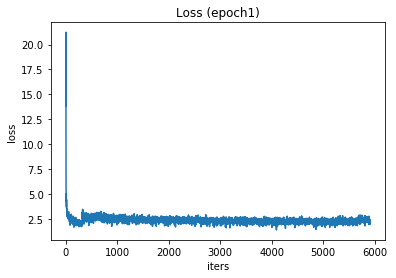

--------------------------Time span: 900.0828375816345 --------------------------
['到', '現在', '我', '還是', '很', '懷疑', '<end>', '<end>', '<end>', '<end>']
[ 0.51  0.28  0.1   0.01  0.03  0.08  0.    0.    0.    0.  ]
['我', '也', '很', '喜歡', '妳', '<end>', '<end>', '<end>', '<end>', '<end>']
[ 0.41  0.25  0.12  0.07  0.15  0.    0.    0.    0.    0.  ]
['我', '也', '很', '喜歡', '妳', '<end>', '<end>', '<end>', '<end>', '<end>']
[ 0.41  0.26  0.11  0.07  0.14  0.    0.    0.    0.    0.  ]
['但是', '我', '真的', '很', '愛妳', '<end>', '<end>', '<end>', '<end>', '<end>']
[ 0.5   0.3   0.08  0.02  0.1   0.    0.    0.    0.    0.  ]
['我', '也', '不想', '想', '辦法', '<end>', '<end>', '<end>', '<end>', '<end>']
[ 0.49  0.34  0.12  0.01  0.05  0.    0.    0.    0.    0.  ]
我也很喜歡妳<end><end><end><end><end>
我也很喜歡妳<end><end><end><end><end>
但是我真的很愛妳<end><end><end><end><end>
我也不想想辦法<end><end><end><end><end>
我也很想幫妳<end><end><end><end>
Epoch: 2 , iter: 800 , loss: 2.17215
Input:到現在我還是很懷疑
['到', '現在', '我', '還是', '很', '懷疑', '<

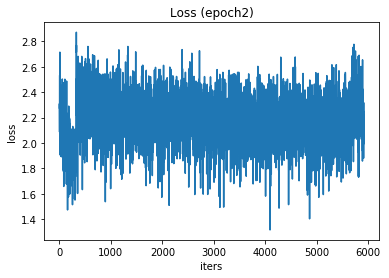

--------------------------Time span: 905.3483664989471 --------------------------
['到', '現在', '我', '還是', '很', '懷疑', '<end>', '<end>', '<end>', '<end>']
[ 0.35  0.22  0.19  0.03  0.04  0.14  0.03  0.    0.    0.  ]
['我', '也', '不', '知道', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>']
[ 0.37  0.23  0.17  0.15  0.08  0.    0.    0.    0.    0.  ]
['我', '不', '是', '不', '知道', '<end>', '<end>', '<end>', '<end>', '<end>']
[ 0.4   0.24  0.13  0.1   0.08  0.05  0.    0.    0.    0.  ]
['我', '不', '是', '不', '知道', '<end>', '<end>', '<end>', '<end>', '<end>']
[ 0.4   0.25  0.13  0.09  0.07  0.05  0.    0.    0.    0.  ]
['我', '不', '是', '不', '知道', '<end>', '<end>', '<end>', '<end>', '<end>']
[ 0.39  0.23  0.14  0.1   0.08  0.06  0.    0.    0.    0.  ]
我也不知道<end><end><end><end><end><end>
我不是不知道<end><end><end><end><end>
我不是不知道<end><end><end><end><end>
我不是不知道<end><end><end><end><end>
我不是不知道<end><end><end><end><end>
Epoch: 3 , iter: 800 , loss: 2.08444
Input:到現在我還是很懷疑
['到', '現在', '我', '還是', '很', '

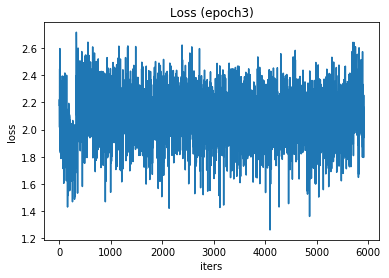

--------------------------Time span: 921.06298995018 --------------------------
['到', '現在', '我', '還是', '很', '懷疑', '<end>', '<end>', '<end>', '<end>']
[ 0.26  0.15  0.17  0.07  0.09  0.15  0.1   0.    0.    0.  ]
['我', '也', '不', '知道', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>']
[ 0.34  0.22  0.18  0.18  0.08  0.    0.    0.    0.    0.  ]
['我', '不', '知道', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>']
[ 0.42  0.26  0.23  0.08  0.    0.    0.    0.    0.    0.  ]
['我', '也', '不', '知道', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>']
[ 0.34  0.21  0.17  0.19  0.09  0.    0.    0.    0.    0.  ]
['我', '也', '不', '知道', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>']
[ 0.37  0.22  0.17  0.18  0.06  0.    0.    0.    0.    0.  ]
我也不知道<end><end><end><end><end><end>
我不知道<end><end><end><end><end><end><end>
我也不知道<end><end><end><end><end><end>
我也不知道<end><end><end><end><end><end>
我也不知道<end><end><end><end><end><end>
Epoch: 4 , iter: 800 , loss: 2.0294
Input:到現在我還是

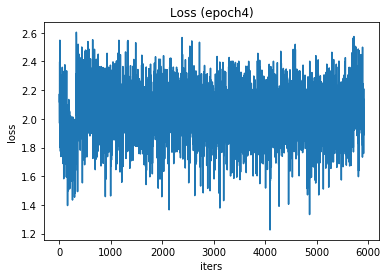

--------------------------Time span: 920.5108942985535 --------------------------
['到', '現在', '我', '還是', '很', '懷疑', '<end>', '<end>', '<end>', '<end>']
[ 0.23  0.15  0.15  0.09  0.09  0.17  0.11  0.    0.    0.  ]
['我', '也', '不', '知道', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>']
[ 0.39  0.24  0.14  0.19  0.05  0.    0.    0.    0.    0.  ]
['妳', '不', '是', '說', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>']
[ 0.37  0.23  0.13  0.2   0.07  0.    0.    0.    0.    0.  ]
['我', '是', '為了', '妳', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>']
[ 0.28  0.16  0.22  0.23  0.1   0.    0.    0.    0.    0.  ]
['我', '才', '不', '相信', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>']
[ 0.34  0.22  0.14  0.19  0.11  0.    0.    0.    0.    0.  ]
我也不知道<end><end><end><end><end><end>
妳不是說<end><end><end><end><end><end>
我是為了妳<end><end><end><end><end><end>
我才不相信<end><end><end><end><end><end>
我不是不知道<end><end><end><end><end>
Epoch: 5 , iter: 800 , loss: 1.98592
Input:到現在我還是很懷疑
['到', '

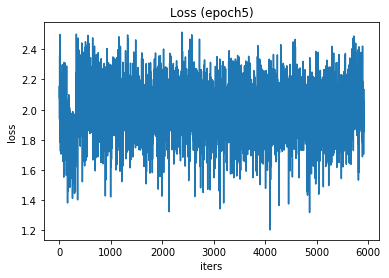

--------------------------Time span: 921.3547682762146 --------------------------
['到', '現在', '我', '還是', '很', '懷疑', '<end>', '<end>', '<end>', '<end>']
[ 0.22  0.15  0.15  0.09  0.09  0.17  0.14  0.    0.    0.  ]
['你', '怎麼', '可以', '這樣', '對', '我', '<end>', '<end>', '<end>', '<end>']
[ 0.25  0.23  0.13  0.13  0.1   0.13  0.03  0.    0.    0.  ]
['我', '不', '是', '不', '知道', '<end>', '<end>', '<end>', '<end>', '<end>']
[ 0.37  0.23  0.12  0.11  0.18  0.    0.    0.    0.    0.  ]
['妳', '是', '我', '的', '女兒', '<end>', '<end>', '<end>', '<end>', '<end>']
[ 0.25  0.15  0.17  0.08  0.23  0.11  0.    0.    0.    0.  ]
['我', '是', '妳', '的', '女兒', '<end>', '<end>', '<end>', '<end>', '<end>']
[ 0.24  0.13  0.17  0.11  0.24  0.11  0.    0.    0.    0.  ]
你怎麼可以這樣對我<end><end><end><end>
我不是不知道<end><end><end><end><end>
妳是我的女兒<end><end><end><end><end>
我是妳的女兒<end><end><end><end><end>
妳怎麼可以這麼自私<end><end><end><end><end>
Epoch: 6 , iter: 800 , loss: 1.95062
Input:到現在我還是很懷疑
['到', '現在', '我', '還是', '很', '懷疑', '<en

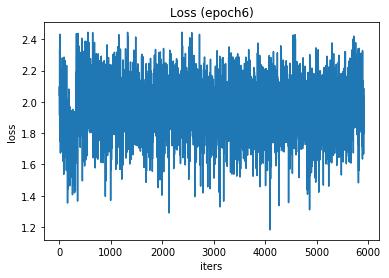

--------------------------Time span: 924.6679439544678 --------------------------
['到', '現在', '我', '還是', '很', '懷疑', '<end>', '<end>', '<end>', '<end>']
[ 0.22  0.16  0.14  0.09  0.09  0.17  0.12  0.    0.    0.  ]
['你', '是', '我', '的', '男朋友', '<end>', '<end>', '<end>', '<end>', '<end>']
[ 0.27  0.16  0.17  0.1   0.2   0.1   0.    0.    0.    0.  ]
['我', '不', '是', '不', '知道', '<end>', '<end>', '<end>', '<end>', '<end>']
[ 0.37  0.24  0.13  0.08  0.17  0.    0.    0.    0.    0.  ]
['妳', '不', '是', '不', '知道', '<end>', '<end>', '<end>', '<end>', '<end>']
[ 0.37  0.25  0.14  0.1   0.14  0.    0.    0.    0.    0.  ]
['我', '是', '為了', '妳', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>']
[ 0.26  0.15  0.23  0.21  0.13  0.01  0.    0.    0.    0.  ]
你是我的男朋友<end><end><end><end><end>
我不是不知道<end><end><end><end><end>
妳不是不知道<end><end><end><end><end>
我是為了妳<end><end><end><end><end><end>
妳不是不知道<end><end><end><end><end>
Epoch: 7 , iter: 800 , loss: 1.91936
Input:到現在我還是很懷疑
['到', '現在', '我', '還是', '很',

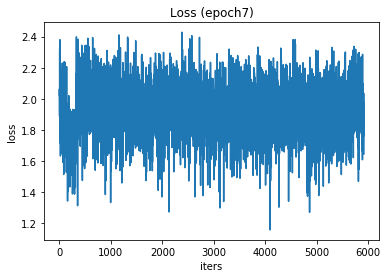

--------------------------Time span: 922.0791590213776 --------------------------
['到', '現在', '我', '還是', '很', '懷疑', '<end>', '<end>', '<end>', '<end>']
[ 0.21  0.16  0.14  0.09  0.1   0.18  0.13  0.    0.    0.  ]
['我', '真的', '很', '喜歡', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>']
[ 0.27  0.19  0.15  0.21  0.15  0.02  0.    0.    0.    0.  ]
['我', '真的', '很', '喜歡', '妳', '<end>', '<end>', '<end>', '<end>', '<end>']
[  2.18e-01   1.54e-01   1.19e-01   1.78e-01   2.04e-01   1.27e-01
   2.17e-04   2.17e-04   2.17e-04   2.17e-04]
['妳', '不', '喜歡', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>']
[ 0.31  0.22  0.24  0.17  0.06  0.    0.    0.    0.    0.  ]
['我', '不', '喜歡', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>']
[ 0.31  0.21  0.25  0.15  0.07  0.    0.    0.    0.    0.  ]
我真的很喜歡<end><end><end><end><end><end>
我真的很喜歡妳<end><end><end><end><end>
妳不喜歡<end><end><end><end><end><end><end>
我不喜歡<end><end><end><end><end><end><end>
我不喜歡<end><end><end><end><en

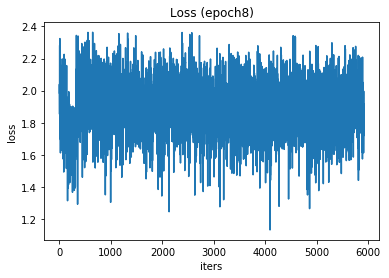

--------------------------Time span: 921.5683007240295 --------------------------


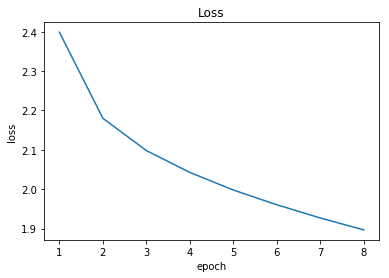

In [7]:
# training
init = tf.global_variables_initializer()
ls = list()
with tf.Session() as sess:
    sess.run(init)
    saver = tf.train.Saver()
    print('Initial state:')
    for epo in range(epoch):
        t_start = time.time()
        inp = '到現在我還是很懷疑'
        r = next_n_sent(inp, 5)
        for j in range(len(r)):
            print(''.join(r[j]))
        l = list()
        for i in range(int(len(dloader.sent_seg)/batch_size)):
            batch_x = dloader.batch_X(i*batch_size, batch_size)
            batch_y = dloader.batch_Y(i*batch_size, batch_size)
            feed_dict = {word_vec[t]: batch_x[:, t] for t in range(enc_len)}
            feed_dict.update({word_target[t]: batch_y[:, t] for t in range(dec_len)})
            _, lo = sess.run([update_step, loss_all], feed_dict=feed_dict)
            l.append(lo)
            # show the testing every 800 iters
            if (i+1)%800 == 0:
                print('Epoch:', epo+1, 
                      ', iter:', i+1, 
                      ', loss:', np.mean(l))
                print('Input:'+''.join(inp))
                sent = next_sent(inp)
                print('Output:', ''.join(sent))
                print('------------------------------------------------------------------------------')
        ls.append(np.mean(l))
        #-----test-----
        inp = '改天要麻煩你一件事'
        resp = next_n_sent(inp, 5)
        print('Input: '+''.join(inp))
        print('Output: ')
        for j in range(len(resp)):
            print(''.join(resp[j]))
        # plot the loss
        plt.plot(np.arange(len(l)), l)
        plt.title('Loss (epoch'+str(epo+1)+')')
        plt.xlabel('iters')
        plt.ylabel('loss')
        plt.show()
        t_end = time.time()
        print('--------------------------Time span:', t_end-t_start, '--------------------------')
    s2s.save_model(sess=sess,
                   saver=saver,
                   name='test')
    s2s.save_model_params_meta()
    # plot the loss
    plt.plot(np.arange(len(ls))+1, ls)
    plt.title('Loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()